In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import sympy

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

In [2]:
n_bar = 5
N = 16

# MSDS

In [3]:
def msds(N,arr):
    w_e = 0
    e_e = 0
    n_e = 0
    s_e = 0
    nw_e = 0
    ne_e = 0
    sw_e = 0
    se_e = 0
    for row in range(arr.shape[0] // N):
        for col in range(arr.shape[1] // N):
            f_block = arr[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # w
            if col == 0:
                w_block = np.fliplr(f_block)
            else:
                w_block = arr[row * N : (row + 1) * N, (col - 1) * N : col * N]
            # e
            if col == arr.shape[1] // N - 1:
                e_block = np.fliplr(f_block)
            else:
                e_block = arr[row * N : (row + 1) * N, (col + 1) * N : (col + 2) * N]
            # n
            if row == 0:
                n_block = np.flipud(f_block)
            else:
                n_block = arr[(row - 1) * N : row * N, col * N : (col + 1) * N]
            # s
            if row == arr.shape[0] // N - 1:
                s_block = np.flipud(f_block)
            else:
                s_block = arr[(row + 1) * N : (row + 2) * N, col * N : (col + 1) * N]

            w_d1 = f_block[:, 0] - w_block[:, N-1]
            e_d1 = f_block[:, N-1] - e_block[:, 0]
            n_d1 = f_block[0, :] - n_block[N-1, :]
            s_d1 = f_block[N-1, :] - s_block[0, :]

            w_d2 = (w_block[:, N-1] - w_block[:, N-2] + f_block[:, 1] - f_block[:, 0]) / 2
            e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, N-1] - f_block[:, N-2]) / 2
            n_d2 = (n_block[N-1, :] - n_block[N-2, :] + f_block[1, :] - f_block[0, :]) / 2
            s_d2 = (s_block[1, :] - s_block[0, :] + f_block[N-1, :] - f_block[N-2, :]) / 2

            w_e += np.sum((w_d1 - w_d2) ** 2 )
            e_e += np.sum((e_d1 - e_d2) ** 2 )
            n_e += np.sum((n_d1 - n_d2) ** 2)
            s_e += np.sum((s_d1 - s_d2) ** 2)

            # nw
            if row == 0 or col == 0:
                nw_block = np.flipud(np.fliplr(f_block))
            else:
                nw_block = arr[(row - 1) * N : row * N, (col - 1) * N : col * N]
            # ne
            if row == 0 or col == arr.shape[1] // N - 1:
                ne_block = np.flipud(np.fliplr(f_block))
            else:
                ne_block = arr[(row-1) * N : row * N, (col + 1) * N : (col + 2) * N]
            # sw
            if row == arr.shape[0] // N -1 or col == 0:
                sw_block = np.flipud(np.fliplr(f_block))
            else:
                sw_block = arr[row * N : (row+1) * N, (col-1) * N : col * N]
            # se
            if  row == arr.shape[0]//N-1 or col == arr.shape[0] // N -1:
                se_block = np.flipud(np.fliplr(f_block))
            else:
                se_block = arr[(row + 1) * N : (row + 2) * N, (col+1) * N : (col + 2) * N]

            nw_g1 = f_block[0, 0] - nw_block[N-1, N-1]
            ne_g1 = f_block[0, N-1] - ne_block[N-1, 0]
            sw_g1 = f_block[N-1, 0] - sw_block[0, N-1]
            se_g1 = f_block[N-1, N-1] - se_block[0, 0]

            nw_g2 = (nw_block[N-1,N-1] - nw_block[N-2,N-2] + f_block[1,1] - f_block[0,0])/2
            ne_g2 = (ne_block[N-1,0] - ne_block[N-2,1] + f_block[1,N-2] - f_block[0,N-1])/2
            sw_g2 = (sw_block[0,N-1] - nw_block[1,N-2] + f_block[N-2,1] - f_block[N-1,0])/2
            se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[N-2,N-2] - f_block[N-1,N-1])/2

            nw_e += (nw_g1 - nw_g2) ** 2 
            ne_e += (ne_g1 - ne_g2) ** 2 
            sw_e += (sw_g1 - sw_g2) ** 2 
            se_e += (se_g1 - se_g2) ** 2 

    MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    MSDS1 = (w_e + e_e + n_e + s_e)/ ((arr.shape[0]/N)**2)
    MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    return MSDSt, MSDS1, MSDS2

In [4]:
class DMLCT:
    def __init__(self, n_bar, N):
        self.n_bar = n_bar
        self.N = N

        self.x_l = (2 * np.arange(N) + 1) / (2 * N)
        self.s_l = np.arange(n_bar) / (n_bar - 1)
        self.xi = (np.arange(n_bar + 1) - 0.5) / (n_bar - 1)

        self.lambda_kh = self.get_lambda_kh(self.n_bar)

        self.w_k_j = self.get_w_k_j(self.n_bar, self.N)
        self.W_L_k_kh = self.get_W_L_k_kh(self.n_bar, self.N)
        self.W_k_kh = self.get_W_k_kh(self.n_bar, self.N)
        self.W_R_k_kh = self.get_W_R_k_kh(self.n_bar, self.N)

    def Lagrange_j(self, j):
        x = sympy.Symbol("x")
        L_x = 1.0
        for l in range(self.n_bar):
            if l != j:
                L_x *= (x - self.s_l[l]) / (self.s_l[j] - self.s_l[l])
        return sympy.integrate(L_x)

    def get_lambda_kh(self, n_bar):
        lambda_kh = np.ones(n_bar)
        lambda_kh[0] = np.sqrt(1 / 2)
        return lambda_kh

    def get_w_k_j(self, n_bar, N):
        L_j = np.zeros((n_bar, N))
        x = sympy.Symbol("x")
        for j in range(n_bar):
            temp = []
            Lj = self.Lagrange_j(j)
            for k in range(N):
                temp.append(Lj.subs(x, self.x_l[k]))
            L_j[j] = np.array(temp)

        w_k_j = np.zeros((n_bar, N))
        for j in range(n_bar):
            w_k_j[j] = scipy.fftpack.dct(L_j[j], norm="ortho")
        return w_k_j

    def get_W_L_k_kh(self, n_bar, N):
        W_L_k_kh = np.zeros((n_bar - 1, N))
        lambda_kh = self.get_lambda_kh(n_bar)

        for kh in range(n_bar - 1):
            W_L_k_kh[kh] = (
                (1 - n_bar)
                * np.sqrt(2 / N)
                * lambda_kh[kh]
                * np.cos(np.pi * kh * (self.xi[0] + 1))
                * self.w_k_j[0]
            )
        return W_L_k_kh

    def get_W_k_kh(self, n_bar, N):
        W_k_kh = np.zeros((n_bar - 1, N))
        for kh in range(n_bar - 1):
            sum_sin = np.zeros(N)
            for j in range(1, n_bar - 2 + 1):
                sum_sin += np.sin(np.pi * kh * self.s_l[j]) * self.w_k_j[j]

            W_k_kh[kh] = (
                (n_bar - 1)
                * np.sqrt(2 / N)
                * self.lambda_kh[kh]
                * (
                    np.cos(np.pi * kh * self.xi[1])
                    * (self.w_k_j[0] - (-1) ** (kh) * self.w_k_j[n_bar - 1])
                    - 2 * np.sin((np.pi * kh) / (2 * (n_bar - 1))) * sum_sin
                )
            )
        return W_k_kh

    def get_W_R_k_kh(self, n_bar, N):
        W_R_k_kh = np.zeros((n_bar - 1, N))
        for kh in range(n_bar - 1):
            W_R_k_kh[kh] = (
                (n_bar - 1)
                * np.sqrt(2 / N)
                * self.lambda_kh[kh]
                * np.cos(np.pi * kh * (self.xi[n_bar] - 1))
                * self.w_k_j[n_bar - 1]
            )
        return W_R_k_kh

In [5]:
def get_F_L_k_horizontal(arr, N, row, col):
    # w
    if col == 0:
        w_block = np.zeros(N)
    else:
        w_block = arr[row, (col - 1) * N : col * N]

    return w_block

In [6]:
def get_F_R_k_horizontal(arr, N, row, col):
    # e
    if col == arr.shape[1] // N - 1:
        e_block = np.zeros(N)
    else:
        e_block = arr[row, (col + 1) * N : (col + 2) * N]

    return e_block

In [7]:
def get_F_L_k_vertical(arr, N, row, col):
    # n
    if row == 0:
        n_block = np.zeros(N)
    else:
        n_block = arr[(row - 1) * N : row * N, col]

    return n_block

In [8]:
def get_F_R_k_vertical(arr, N, row, col):
    # s
    if row == arr.shape[0] // N - 1:
        s_block = np.zeros(N)
    else:
        s_block = arr[(row + 1) * N : (row + 2) * N, col]

    return s_block

In [9]:
# dmlct = DMLCT(n_bar, N)

In [10]:
IMG = MILKDROP
# IMG = ImageLoader(MONO_DIR_PATH + "LENNA.bmp")

In [11]:
Fk = np.zeros(IMG.img.shape)

# 順変換

## 縦方向

### DCT

In [12]:
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        eight_points = IMG.img[N * row : N * (row + 1), col]
        c = scipy.fftpack.dct(eight_points, norm="ortho")
        Fk[N * row : N * (row + 1), col] = c

### 残差

In [13]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        # ビューなら直接いじっちゃう
        F = Fk[N * row : N * (row + 1), col]
        F_L = get_F_L_k_vertical(Fk, N, row, col)
        F_R = get_F_R_k_vertical(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] -= U_k_n_bar[n_bar - 2 + 1 :]

In [14]:
# 0を残す
for k in reversed(range(1, n_bar - 2 + 1)):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] -= U_k_n_bar[k]

## 横方向

### DCT

In [15]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // N):
        eight_points = Fk[row, N * col : N * (col + 1)]
        c = scipy.fftpack.dct(eight_points, norm="ortho")
        Fk[row, N * col : N * (col + 1)] = c

### 残差

In [16]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0]):
    for col in range(IMG.img.shape[1] // N):
        F = Fk[row, N * col : N * (col + 1)]
        F_L = get_F_L_k_horizontal(Fk, N, row, col)
        F_R = get_F_R_k_horizontal(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] -= U_k_n_bar[n_bar - 2 + 1 :]

In [17]:
# 0を残す
for k in reversed(range(1, n_bar - 2 + 1)):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] -= U_k_n_bar[k]

findfont: Font family ['Source Han Sans JP'] not found. Falling back to DejaVu Sans.


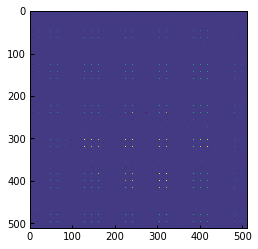

In [18]:
plt.imshow(Fk)
pd.DataFrame(Fk).to_csv("DMLCT_coef.csv",header=False,index=False)

# 係数の確保

In [19]:
Fk_Ori = np.copy(Fk)

# 逆変換

In [20]:
recover = np.zeros(IMG.img.shape)

## 横方向

### 残差

In [21]:
for k in range(1, n_bar - 2 + 1):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [22]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0]):
    for col in range(IMG.img.shape[1] // N):
        F = Fk[row, N * col : N * (col + 1)]
        F_L = get_F_L_k_horizontal(Fk, N, row, col)
        F_R = get_F_R_k_horizontal(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [23]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // N):
        F = Fk[row, N * col : N * col + N]
        data = scipy.fftpack.idct(F, norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, N * col : N * col + N] = data

## 縦方向

### 残差

In [24]:
for k in range(1, n_bar - 2 + 1):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [25]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        # ビューなら直接いじっちゃう
        F = Fk[N * row : N * (row + 1), col]
        F_L = get_F_L_k_vertical(Fk, N, row, col)
        F_R = get_F_R_k_vertical(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [26]:
for row in range(Fk.shape[0] // N):
    for col in range(Fk.shape[1]):
        F = Fk[N * row : N * (row + 1), col]
        data = scipy.fftpack.idct(F, norm="ortho")
        # 復元画像
        recover[N * row : N * (row + 1), col] = data

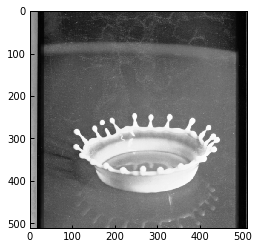

In [27]:
plt.imshow(recover.astype("u8"), cmap="gray")

もどった...！

# 量子化テーブル

In [28]:
# Q=80における量子化テーブルをスケーリング
for i in tqdm_notebook(np.arange(1,1600,1)):
    Q = 72 - i/8
    Q_Luminance = np.ones((16,16)) * Q
    
    Fk = np.copy(Fk_Ori)
    Q_Fk = np.zeros(Fk.shape)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1] // N):
            block = Fk[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # 量子化
            block = np.round(block / Q_Luminance)
            # 逆量子化
            block = block * Q_Luminance
            Q_Fk[row * N : (row+1)*N, col * N : (col+1)*N] = block

    Fk = np.copy(Q_Fk)
    Q_recover = np.zeros(Q_Fk.shape)
    # 横方向
    # 残差
    for k in range(1, n_bar - 2 + 1):
        dmlct = DMLCT(k+1, N)
        for row in range(IMG.img.shape[0]):
            for col in range(IMG.img.shape[1] // N):
                F = Fk[row, N * col : N * (col + 1)]
                F_L = get_F_L_k_horizontal(Fk, N, row, col)
                F_R = get_F_R_k_horizontal(Fk, N, row, col)

                U_k_n_bar = np.zeros(N)
                for kh in range((k + 1) - 2 + 1):
                    U_k_n_bar += (
                        F_L[kh] * dmlct.W_L_k_kh[kh]
                        + F[kh] * dmlct.W_k_kh[kh]
                        + F_R[kh] * dmlct.W_R_k_kh[kh]
                    )

                F[k] += U_k_n_bar[k]

    dmlct = DMLCT(n_bar, N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range(n_bar - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
            F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]
    ### IDCT
    for row in range(Fk.shape[0]):
        for col in range(Fk.shape[1] // N):
            F = Fk[row, N * col : N * col + N]
            data = scipy.fftpack.idct(F, norm="ortho")
            # Fkに代入した後、縦方向に対して処理
            Fk[row, N * col : N * col + N] = data

    ## 縦方向
    ### 残差
    for k in range(1, n_bar - 2 + 1):
        dmlct = DMLCT(k+1, N)
        for row in range(IMG.img.shape[0] // N):
            for col in range(IMG.img.shape[1]):
                # ビューなら直接いじっちゃう
                F = Fk[N * row : N * (row + 1), col]
                F_L = get_F_L_k_vertical(Fk, N, row, col)
                F_R = get_F_R_k_vertical(Fk, N, row, col)

                U_k_n_bar = np.zeros(N)

                for kh in range((k + 1) - 2 + 1):
                    U_k_n_bar += (
                        F_L[kh] * dmlct.W_L_k_kh[kh]
                        + F[kh] * dmlct.W_k_kh[kh]
                        + F_R[kh] * dmlct.W_R_k_kh[kh]
                    )

                F[k] += U_k_n_bar[k]

    dmlct = DMLCT(n_bar, N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range(n_bar - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
            F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

    ### IDCT
    for row in range(Fk.shape[0] // N):
        for col in range(Fk.shape[1]):
            F = Fk[N * row : N * (row + 1), col]
            data = scipy.fftpack.idct(F, norm="ortho")
            # 復元画像
            Q_recover[N * row : N * (row + 1), col] = data

    Q_recover = np.round(Q_recover)
    qfk = pd.Series(Q_Fk.flatten())
    pro = qfk.value_counts() / qfk.value_counts().sum()
    S = 0
    for pi in pro:
        S -= pi * np.log2(pi)

    MSE = np.sum(np.sum(np.power((IMG.img - Q_recover),2)))/(Q_recover.shape[0] * Q_recover.shape[1])
    PSNR = 10 * np.log10(255 * 255 / MSE)
    MSSIM = ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)
    MSDSt, MSDS1, MSDS2 = msds(N,Q_recover)
    print("S=",S)
    print(Q,PSNR,MSSIM,MSDS1,MSDS2)

S= 0.19717182327622182
71.875 33.08431513278328 0.8192030200893287 7059.82373046875 1874.083740234375
S= 0.19758664719793662
71.75 33.084966706260495 0.8191035066232025 7045.29345703125 1881.7548828125
S= 0.19780567917656205
71.625 33.088722026683044 0.8187882441138224 7041.5126953125 1882.27734375
S= 0.19794396953986154
71.5 33.09475361602425 0.8189590016582501 7027.171875 1880.410888671875
S= 0.19812164765173182
71.375 33.109839361069426 0.8198218781730994 7025.751953125 1888.027587890625
S= 0.19840113837049492
71.25 33.118584796399155 0.8197027942572113 7073.67431640625 1894.756591796875
S= 0.19847058764484085
71.125 33.13305649653354 0.819773627907634 7083.5498046875 1888.096923828125
S= 0.19870485686984116
71.0 33.147177950104066 0.8206008441970696 7069.8046875 1896.704833984375
S= 0.19886803452173168
70.875 33.15419509610452 0.8207848291096997 7033.986328125 1885.691650390625
S= 0.19912289403062303
70.75 33.16648356618464 0.820887874215556 6999.67236328125 1883.84130859375
S= 0.1

c:\users\hiro\documents\github\python_dct\venv\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars


S= 6.076435496623263
0.25 inf 1.0 5659.26171875 1836.59033203125
S= 7.066916520958104
0.125 inf 1.0 5659.26171875 1836.59033203125


c:\users\hiro\documents\github\python_dct\venv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
c:\users\hiro\documents\github\python_dct\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


S= 0
0.0 nan 0.0019736293868016586 nan nan
S= 7.066916520958104
-0.125 inf 1.0 5659.26171875 1836.59033203125
S= 6.076435496623263
-0.25 inf 1.0 5659.26171875 1836.59033203125
S= 5.496427088162221
-0.375 99.3059028715559 0.9999998930953236 5659.27001953125 1836.59033203125
S= 5.0853000305993
-0.5 80.85492247141333 0.9999942500856323 5659.65380859375 1836.5947265625
S= 4.765762481242578
-0.625 70.43817644101152 0.999939159016657 5659.8583984375 1836.72265625
S= 4.505814555115399
-0.75 64.83354710150832 0.999777282223339 5662.90869140625 1835.869384765625
S= 4.28665279298987
-0.875 61.22886174217207 0.9994949711360906 5669.3076171875 1837.5732421875
S= 4.096713704509772
-1.0 58.82673216893974 0.9991199757422021 5673.85205078125 1837.588134765625
S= 3.9298132682120817
-1.125 57.101422220852726 0.9986898126975962 5683.2109375 1838.0517578125
S= 3.780950479321105
-1.25 55.85491141022695 0.9982670375291045 5689.76416015625 1839.9443359375
S= 3.6465487199803315
-1.375 54.863736820859714 0.997

KeyboardInterrupt: 